In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

# Define the project path
PROJECT_PATH = Path('/content/drive/MyDrive/AutomaticHeartSoundClassification-main')
sys.path.append(str(PROJECT_PATH))

# Define the dataset path
DATASET_PATH = Path('/content/drive/MyDrive/physionet2016')



```
<base>/
├── annotations/
├── papers/
├── sources/
├── training-a/
├── training-b/
├── training-c/
├── training-d/
├── training-e/
├── training-f/
├── validation/
├── training.zip
├── validation.zip
└── README / figure / sample files
```






```
training-a/
├── a0001.wav
├── a0001.hea
├── a0001.dat
├── a0002.wav
├── a0002.hea
├── a0002.dat
├── ...
├── REFERENCE.csv
├── REFERENCE-SQI.csv
├── RECORDS
├── RECORDS-normal
├── RECORDS-abnormal
├── MD5SUMS / SHA1SUMS / SHA256SUMS
```



In [3]:
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
import soundfile
import h5py
import random
import h5py
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Sampler, DataLoader
import json
import torch
import librosa
from pathlib import Path
from itertools import repeat
from collections import OrderedDict
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
import glob
import os
from collections import Counter

import librosa

In [4]:
wav_files = glob.glob("/content/drive/MyDrive/physionet2016/training-*/*.wav")

normal_files = []
abnormal_files = []

for f in wav_files:
    hea_file = f.replace(".wav", ".hea")
    if os.path.exists(hea_file):
        with open(hea_file, "r") as hf:
            for line in hf:
                line = line.strip().lower()
                if line.startswith("# normal"):
                    normal_files.append(f)
                    break
                elif line.startswith("# abnormal"):
                    abnormal_files.append(f)
                    break

print("Tổng số file:", len(wav_files))
print("Normal:", len(normal_files))
print("Abnormal:", len(abnormal_files))

Tổng số file: 3240
Normal: 2575
Abnormal: 665


# Đọc audio & tiền xử lý tín hiệu

In [5]:
lowcut = 20      # Hz
highcut = 600    # Hz
fs = 2000        # Hz
order = 4

In [6]:
def read_audio(path, target_fs=None, filter=False,
               lowcut=lowcut, hightcut=highcut):
    (audio, fs) = soundfile.read(path)

    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)

    if target_fs is not None and fs != target_fs:
        audio = librosa.resample(audio, orig_sr = fs, target_sr = target_fs)
        fs = target_fs
    if filter:
        # apply bandpass filter
        audio = butter_bandpass_filter(audio, lowcut, hightcut, fs, order)
    return audio, fs

In [7]:
def butter_bandpass(lowcut, hightcut, fs, order=order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = hightcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, hightcut, fs, order):
    b, a = butter_bandpass(lowcut, hightcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [8]:
'''
def augment_audio(audio, fs):
    """Apply random augmentations to audio signal."""
    if random.random() < 0.5:
        # Add Gaussian noise
        noise = np.random.normal(0, 0.01 * np.std(audio), len(audio))
        audio += noise

    if random.random() < 0.5:
        # Time shift (roll)
        shift = random.randint(-len(audio)//10, len(audio)//10)
        audio = np.roll(audio, shift)

    if random.random() < 0.5:
        # Pitch shift
        n_steps = random.uniform(-2, 2)
        audio = librosa.effects.pitch_shift(audio, sr=fs, n_steps=n_steps)

    if random.random() < 0.5:
        # Time stretch
        rate = random.uniform(0.8, 1.2)
        audio = librosa.effects.time_stretch(audio, rate=rate)

    if random.random() < 0.2:
        # Polarity inversion
        audio = -audio

    return audio
'''

'\ndef augment_audio(audio, fs):\n    """Apply random augmentations to audio signal."""\n    if random.random() < 0.5:\n        # Add Gaussian noise\n        noise = np.random.normal(0, 0.01 * np.std(audio), len(audio))\n        audio += noise\n\n    if random.random() < 0.5:\n        # Time shift (roll)\n        shift = random.randint(-len(audio)//10, len(audio)//10)\n        audio = np.roll(audio, shift)\n\n    if random.random() < 0.5:\n        # Pitch shift\n        n_steps = random.uniform(-2, 2)\n        audio = librosa.effects.pitch_shift(audio, sr=fs, n_steps=n_steps)\n\n    if random.random() < 0.5:\n        # Time stretch\n        rate = random.uniform(0.8, 1.2)\n        audio = librosa.effects.time_stretch(audio, rate=rate)\n\n    if random.random() < 0.2:\n        # Polarity inversion\n        audio = -audio\n\n    return audio\n'

In [9]:
import numpy as np
import random
import librosa

def augment_audio(audio, fs, label=None):
    """
    Data augmentation for PCG signals based on PhysioNet 2016 setting.

    Augmentations are preferentially applied to the abnormal class
    to mitigate class imbalance.

    Parameters
    ----------
    audio : np.ndarray
        Input PCG signal
    fs : int
        Sampling frequency (Hz), typically 2000
    label : int or None
        Class label (0: normal, 1: abnormal)

    Returns
    -------
    audio_aug : np.ndarray
        Augmented audio signal
    """

    audio_aug = audio.copy()

    # Only apply augmentation aggressively to abnormal class
    if label == 1 and random.random() < 0.5:

        # 1. Additive Gaussian noise (α = 0.005)
        if random.random() < 0.5:
            noise = np.random.normal(
                0,
                0.005 * np.std(audio_aug),
                size=len(audio_aug)
            )
            audio_aug = audio_aug + noise

        # 2. Time shift (Δ = ±0.05 * fs = ±100 samples)
        if random.random() < 0.5:
            shift = random.randint(-int(0.05 * fs), int(0.05 * fs))
            audio_aug = np.roll(audio_aug, shift)
            if shift > 0:
                audio_aug[:shift] = 0
            elif shift < 0:
                audio_aug[shift:] = 0

        # 3. Pitch shift (−2 to +2 semitones)
        if random.random() < 0.5:
            n_steps = random.uniform(-2, 2)
            audio_aug = librosa.effects.pitch_shift(
                audio_aug,
                sr=fs,
                n_steps=n_steps
            )

    return audio_aug

## Test

In [10]:
def compute_fft(signal, fs):
    """
    Compute single-sided amplitude spectrum.
    """
    N = len(signal)
    fft_vals = np.fft.rfft(signal)
    fft_mag = np.abs(fft_vals) / N
    freqs = np.fft.rfftfreq(N, d=1/fs)
    return freqs, fft_mag

In [11]:
normal_file = Path(DATASET_PATH/'training-a/a0007.wav')
abnormal_file = Path(DATASET_PATH/'training-a/a0001.wav')

Normal

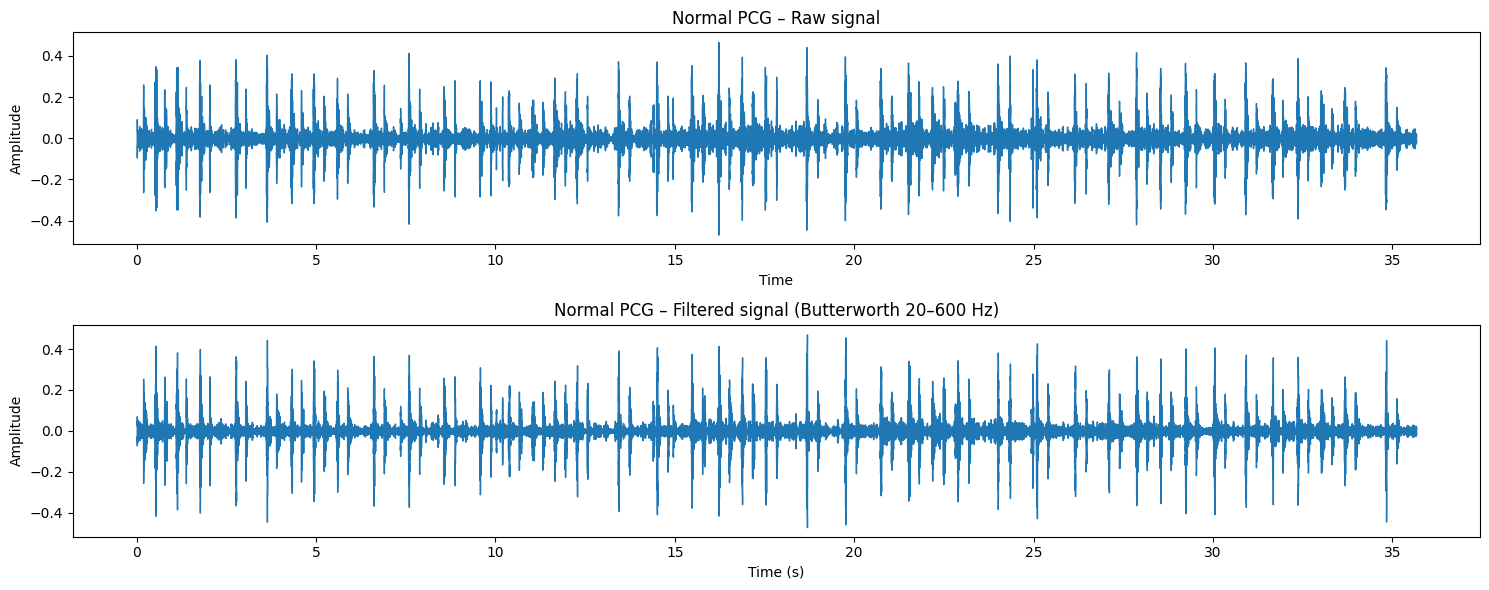

In [15]:
#Miền thời gian
audio_normal_raw, fs = read_audio(str(normal_file), filter=False)
audio_normal_filt, _ = read_audio(str(normal_file), filter=True)

plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
librosa.display.waveshow(audio_normal_raw, sr=fs)
plt.title("Normal PCG – Raw signal")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
librosa.display.waveshow(audio_normal_filt, sr=fs)
plt.title("Normal PCG – Filtered signal (Butterworth 20–600 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


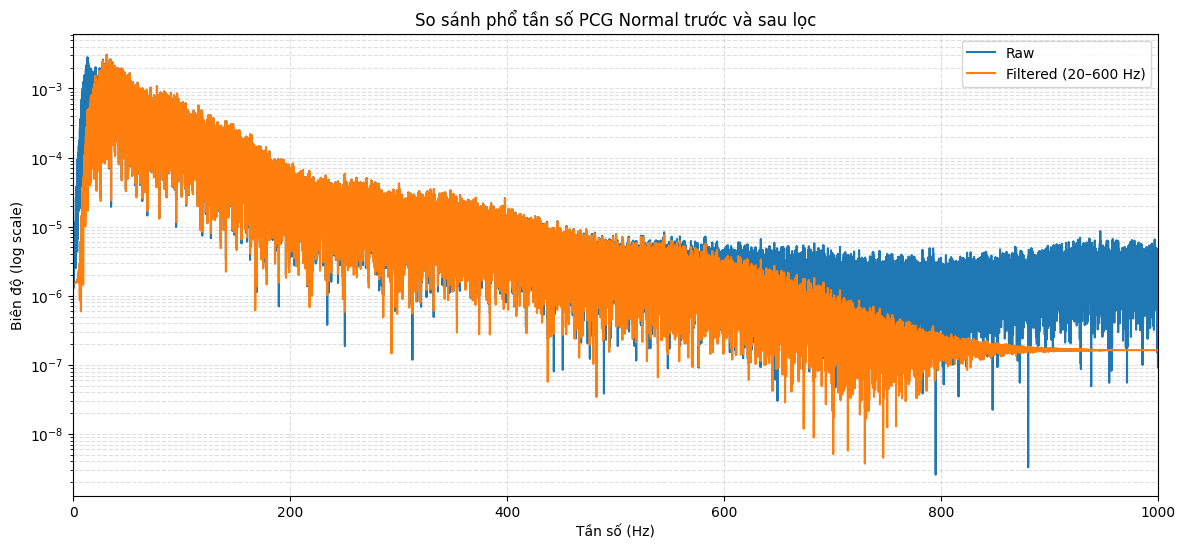

In [16]:
# Miền tần số
freqs_raw, fft_raw = compute_fft(audio_normal_raw, fs)
freqs_filt, fft_filt = compute_fft(audio_normal_filt, fs)

plt.figure(figsize=(14, 6))
plt.semilogy(freqs_raw, fft_raw, label="Raw")
plt.semilogy(freqs_filt, fft_filt, label="Filtered (20–600 Hz)")

plt.xlim(0, 1000)
plt.title("So sánh phổ tần số PCG Normal trước và sau lọc")
plt.xlabel("Tần số (Hz)")
plt.ylabel("Biên độ (log scale)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


Abnormal

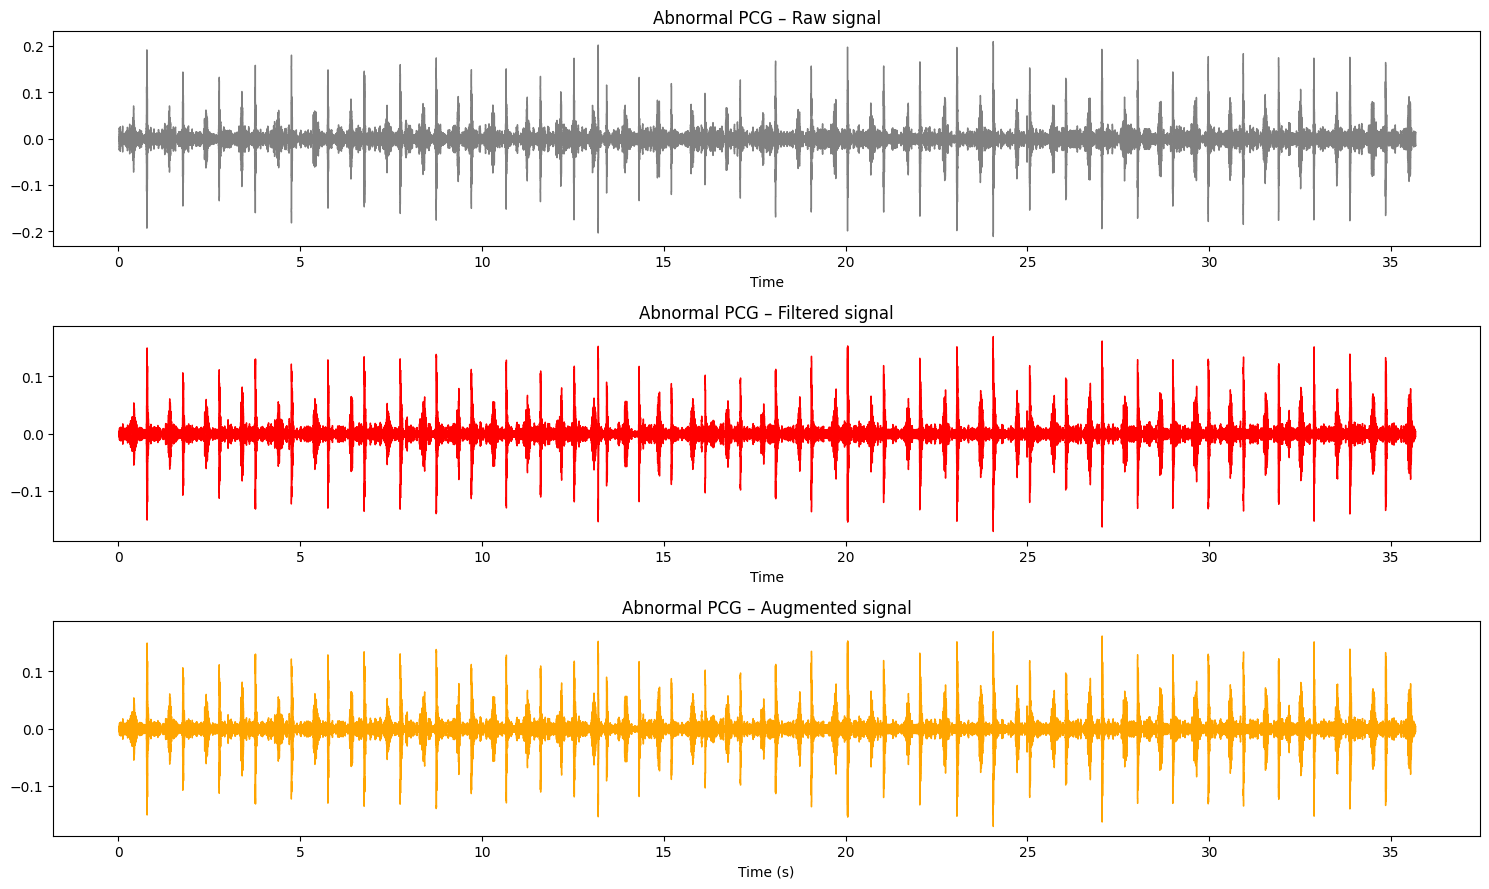

In [17]:
#Miền thời gian
audio_abnormal_raw, fs = read_audio(str(abnormal_file), filter=False)
audio_abnormal_filt, _ = read_audio(str(abnormal_file), filter=True)
audio_abnormal_aug = augment_audio(audio_abnormal_filt, fs, label=1)

plt.figure(figsize=(15, 9))

plt.subplot(3, 1, 1)
librosa.display.waveshow(audio_abnormal_raw, sr=fs, color="gray")
plt.title("Abnormal PCG – Raw signal")

plt.subplot(3, 1, 2)
librosa.display.waveshow(audio_abnormal_filt, sr=fs, color="red")
plt.title("Abnormal PCG – Filtered signal")

plt.subplot(3, 1, 3)
librosa.display.waveshow(audio_abnormal_aug, sr=fs, color="orange")
plt.title("Abnormal PCG – Augmented signal")

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()


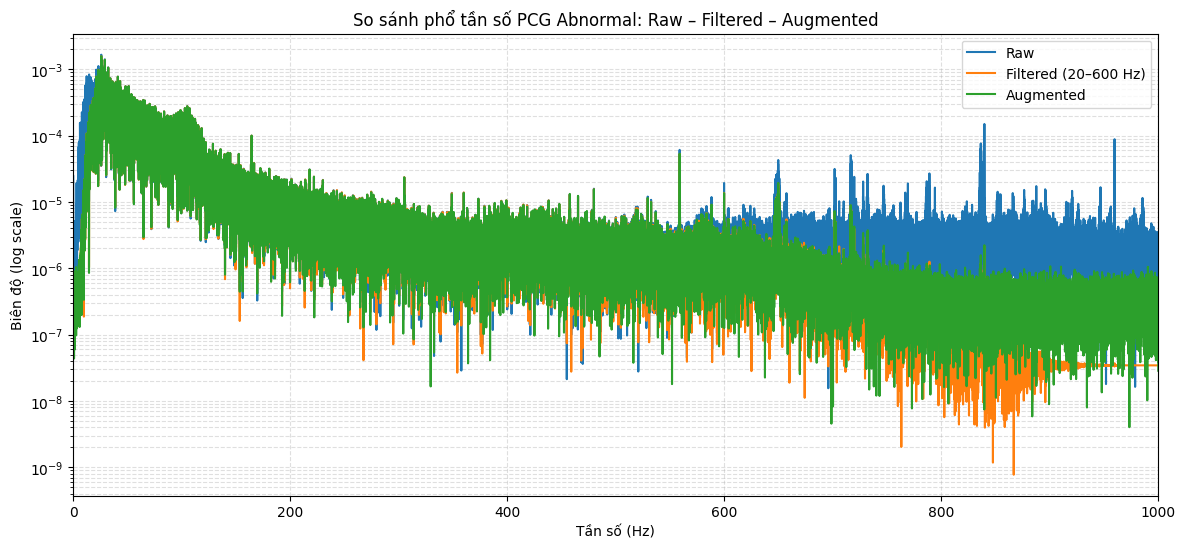

In [18]:
#Miền tần số
freqs_raw, fft_raw = compute_fft(audio_abnormal_raw, fs)
freqs_filt, fft_filt = compute_fft(audio_abnormal_filt, fs)
freqs_aug, fft_aug = compute_fft(audio_abnormal_aug, fs)

plt.figure(figsize=(14, 6))
plt.semilogy(freqs_raw, fft_raw, label="Raw")
plt.semilogy(freqs_filt, fft_filt, label="Filtered (20–600 Hz)")
plt.semilogy(freqs_aug, fft_aug, label="Augmented")

plt.xlim(0, 1000)
plt.title("So sánh phổ tần số PCG Abnormal: Raw – Filtered – Augmented")
plt.xlabel("Tần số (Hz)")
plt.ylabel("Biên độ (log scale)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


# MFCC Extractor

In [19]:
import numpy as np
import librosa

import numpy as np
import librosa

def MfccExtractor(
    data,
    sr,
    n_mfcc=13,
    window='hamming',
    hoplen=15,   # ms
    winlen=25,   # ms
    T_fixed=100,
    snv=False
):
    """
    MFCC extraction pipeline following Viet Hung thesis:
    - Full signal MFCC
    - Temporal truncation / zero-padding to fixed T
    """

    MFCC_ARGS = {
        'n_mfcc': n_mfcc,
        'sr': sr,
        'window': window,
        'hop_length': int(sr * hoplen / 1000),
        'win_length': int(sr * winlen / 1000),
    }

    mfcc = librosa.feature.mfcc(y=data, **MFCC_ARGS)

    if snv:
        mfcc = standard_normal_variate(mfcc)

    # ===== Temporal normalization (KEY STEP) =====
    T = mfcc.shape[1]

    if T >= T_fixed:
        mfcc = mfcc[:, :T_fixed]          # truncation
    else:
        pad = T_fixed - T
        mfcc = np.pad(
            mfcc,
            ((0, 0), (0, pad)),
            mode="constant"
        )

    return mfcc.astype(np.float32)  # (13, 100)

In [20]:
EPS = 1E-8
def LogMelExtractor(
    data,
    sr,
    mel_bins=128,
    hoplen=15,
    winlen=25,
    log=True,
    snv=False
):
    """
    Log-Mel spectrogram extractor
    """

    hop_length = int(sr * hoplen / 1000)
    win_length = int(sr * winlen / 1000)

    mel = librosa.feature.melspectrogram(
        y=data,
        sr=sr,
        n_mels=mel_bins,
        hop_length=hop_length,
        win_length=win_length
    )

    if log:
        mel = np.log(mel + EPS)

    if snv:
        mel = standard_normal_variate(mel)

    return mel.astype(np.float32)

In [21]:
def standard_normal_variate(data):
    mean = np.mean(data)
    std = np.std(data)

    return (data - mean) / std

In [22]:
data_processing_path = Path(PROJECT_PATH) / 'data_processing'
data_processing_path.mkdir(parents=True, exist_ok=True)

In [23]:
import pandas as pd
import os
import sys
from pathlib import Path
from tqdm import tqdm  # Included as in original, though not used here

# Define the training folders based on the provided dataset structure
folders = ['training-a', 'training-b', 'training-c', 'training-d', 'training-e', 'training-f']

# Collect labels from each folder's REFERENCE.csv
dfs = []
for folder in folders:
    ref_path = DATASET_PATH / folder / 'REFERENCE.csv'
    df = pd.read_csv(ref_path, header=None, names=['basename', 'label'])

    # Correct way to create full filenames
    df['filename'] = [str(DATASET_PATH / folder / (base + '.wav')) for base in df['basename']]

    # Convert labels: -1 → 0, 1 → 1 (or abnormal → 1)
    df['label'] = (df['label'] + 1) // 2

    dfs.append(df[['filename', 'label']])

# Concatenate all dataframes and save to label.csv
all_df = pd.concat(dfs, ignore_index=True)
save_path = PROJECT_PATH / 'data' / 'label.csv'
save_dir = save_path.parent
os.makedirs(str(save_dir), exist_ok=True)
all_df.to_csv(str(save_path), index=False)

print(f"Created {str(save_path)} with {len(all_df)} entries.")

Created /content/drive/MyDrive/AutomaticHeartSoundClassification-main/data/label.csv with 3240 entries.


In [24]:
print(type(df['filename']))
print(df['filename'].head(10))
print(repr(df['filename'].iloc[0]))
print("First element type:", type(df['filename'].iloc[0]) if len(df) > 0 else "empty")

<class 'pandas.core.series.Series'>
0    /content/drive/MyDrive/physionet2016/training-...
1    /content/drive/MyDrive/physionet2016/training-...
2    /content/drive/MyDrive/physionet2016/training-...
3    /content/drive/MyDrive/physionet2016/training-...
4    /content/drive/MyDrive/physionet2016/training-...
5    /content/drive/MyDrive/physionet2016/training-...
6    /content/drive/MyDrive/physionet2016/training-...
7    /content/drive/MyDrive/physionet2016/training-...
8    /content/drive/MyDrive/physionet2016/training-...
9    /content/drive/MyDrive/physionet2016/training-...
Name: filename, dtype: object
'/content/drive/MyDrive/physionet2016/training-f/f0001.wav'
First element type: <class 'str'>


In [25]:
import os
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter
from pathlib import Path

# =========================
# read_audio()
# augment_audio()
# PROJECT_PATH
# MfccExtractor()
# LogMelExtractor()
# =========================

if __name__ == "__main__":

    df = pd.read_csv(PROJECT_PATH / "data" / "label.csv")

    logmel_folder = PROJECT_PATH / "logmel_features"
    mfcc_folder   = PROJECT_PATH / "mfcc_features"

    os.makedirs(logmel_folder, exist_ok=True)
    os.makedirs(mfcc_folder, exist_ok=True)

    # ===== Class balancing =====
    label_counts = Counter(df["label"])
    n_normal   = label_counts[0]
    n_abnormal = label_counts[1]

    target_abnormal = n_normal
    augment_per_abnormal = int(
        np.ceil((target_abnormal - n_abnormal) / n_abnormal)
    )

    print("=== ORIGINAL DISTRIBUTION ===")
    print(f"Normal  : {n_normal}")
    print(f"Abnormal: {n_abnormal}")
    print(f"Augment per abnormal sample: {augment_per_abnormal}")

    # ===== Feature parameters =====
    mel_bins = 128
    n_mfcc   = 13
    hoplen   = 15   # ms
    winlen   = 25   # ms
    T_fixed  = 100
    # =========================
    # Feature extraction
    # =========================
    for _, row in tqdm(df.iterrows(), total=len(df)):

        filename = row["filename"]
        label    = row["label"]

        audio, fs = read_audio(filename, filter=True)
        basename = Path(filename).stem

        # ===== ORIGINAL SAMPLE =====
        logmel = LogMelExtractor(
            audio, fs,
            mel_bins=mel_bins,
            hoplen=hoplen,
            winlen=winlen
        )

        mfcc = MfccExtractor(
            audio, fs,
            n_mfcc=n_mfcc,
            hoplen=hoplen,
            winlen=winlen,
            T_fixed=T_fixed
        )

        np.save(logmel_folder / f"{basename}.npy", logmel)
        np.save(mfcc_folder   / f"{basename}.npy", mfcc)

        # ===== AUGMENTATION (Abnormal only) =====
        if label == 1:
            for k in range(augment_per_abnormal):

                aug_audio = augment_audio(audio.copy(), fs)
                aug_name = f"{basename}_aug{k}"

                logmel_aug = LogMelExtractor(
                    aug_audio, fs,
                    mel_bins=mel_bins,
                    hoplen=hoplen,
                    winlen=winlen
                )

                mfcc_aug = MfccExtractor(
                    aug_audio, fs,
                    n_mfcc=n_mfcc,
                    hoplen=hoplen,
                    winlen=winlen,
                    T_fixed=T_fixed
                )

                np.save(logmel_folder / f"{aug_name}.npy", logmel_aug)
                np.save(mfcc_folder   / f"{aug_name}.npy", mfcc_aug)

    print("\n✅ Feature extraction + augmentation completed.")


=== ORIGINAL DISTRIBUTION ===
Normal  : 2575
Abnormal: 665
Augment per abnormal sample: 3


100%|██████████| 3240/3240 [44:37<00:00,  1.21it/s]


✅ Feature extraction + augmentation completed.


In [26]:
logmel_folder = PROJECT_PATH / "logmel_features"
mfcc_folder   = PROJECT_PATH / "mfcc_features"

label_counts = Counter(df["label"])
n_normal   = label_counts[0]
n_abnormal = label_counts[1]

target_abnormal = n_normal
augment_per_abnormal = int(
    np.ceil((target_abnormal - n_abnormal) / n_abnormal)
)

In [27]:
aug_rows = []

for _, row in df.iterrows():
    if row["label"] == 1:
        base = Path(row["filename"]).stem
        for k in range(augment_per_abnormal):
            aug_rows.append({
                "filename": f"{base}_aug{k}",  # hoặc .npy tùy Dataset loader
                "label": 1
            })

df_balanced = pd.concat([df, pd.DataFrame(aug_rows)], ignore_index=True)
df_balanced.to_csv(PROJECT_PATH / "data" / "label_balanced.csv", index=False)

# Test file

In [28]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path

# Root dataset PhysioNet 2016
original_audio_root = Path("/content/drive/MyDrive/physionet2016")

logmel_folder = Path(logmel_folder)
mfcc_folder   = Path(mfcc_folder)

## Normal

[NORMAL] Audio path: /content/drive/MyDrive/physionet2016/training-a/a0007.wav
[NORMAL] Length: 71332 | Duration: 35.67s | SR: 2000
[NORMAL] LogMel shape: (128, 2378)
[NORMAL] MFCC shape: (13, 100)


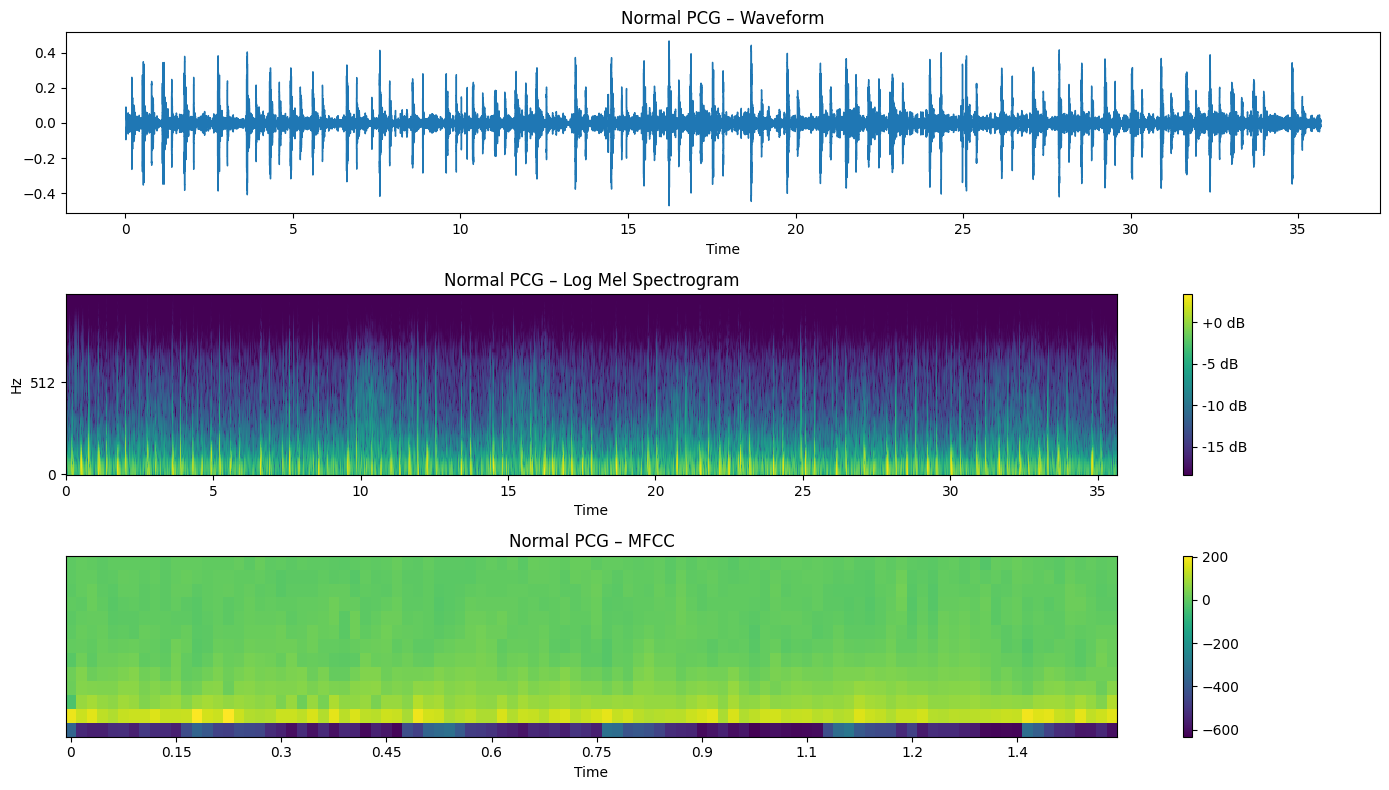

In [29]:
# ========================
# NORMAL SAMPLE
# ========================

normal_file = Path(normal_file)          # ví dụ: a0007.wav
normal_basename = normal_file.stem        # a0007
folder_letter = normal_basename[0]

wav_path = original_audio_root / f"training-{folder_letter}" / normal_file.name
print(f"[NORMAL] Audio path: {wav_path}")

# 1. Load raw audio
audio_norm, sr = librosa.load(wav_path, sr=None)
print(f"[NORMAL] Length: {len(audio_norm)} | Duration: {len(audio_norm)/sr:.2f}s | SR: {sr}")

# 2. Load Log-Mel
logmel_norm = np.load(logmel_folder / f"{normal_basename}.npy")
print(f"[NORMAL] LogMel shape: {logmel_norm.shape}")

# 3. Load MFCC
mfcc_norm = np.load(mfcc_folder / f"{normal_basename}.npy")
print(f"[NORMAL] MFCC shape: {mfcc_norm.shape}")

# 4. Visualization
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
librosa.display.waveshow(audio_norm, sr=sr)
plt.title("Normal PCG – Waveform")

plt.subplot(3, 1, 2)
librosa.display.specshow(
    logmel_norm,
    sr=sr,
    hop_length=int(sr * 15 / 1000),
    x_axis='time',
    y_axis='mel',
    cmap='viridis'
)
plt.colorbar(format='%+2.0f dB')
plt.title("Normal PCG – Log Mel Spectrogram")

plt.subplot(3, 1, 3)
librosa.display.specshow(
    mfcc_norm,
    sr=sr,
    hop_length=int(sr * 15 / 1000),
    x_axis='time',
    cmap='viridis'
)
plt.colorbar()
plt.title("Normal PCG – MFCC")

plt.tight_layout()
plt.show()

## Abnormal

[ABNORMAL] Audio path: /content/drive/MyDrive/physionet2016/training-a/a0001.wav
[ABNORMAL] Length: 71332 | Duration: 35.67s | SR: 2000
[ABNORMAL] LogMel original shape: (128, 2378)
[ABNORMAL] MFCC original shape : (13, 100)
[ABNORMAL] Loaded a0001_aug0.npy | LogMel shape: (128, 2378)
[ABNORMAL] Loaded a0001_aug1.npy | LogMel shape: (128, 2378)
[ABNORMAL] Loaded a0001_aug2.npy | LogMel shape: (128, 2378)


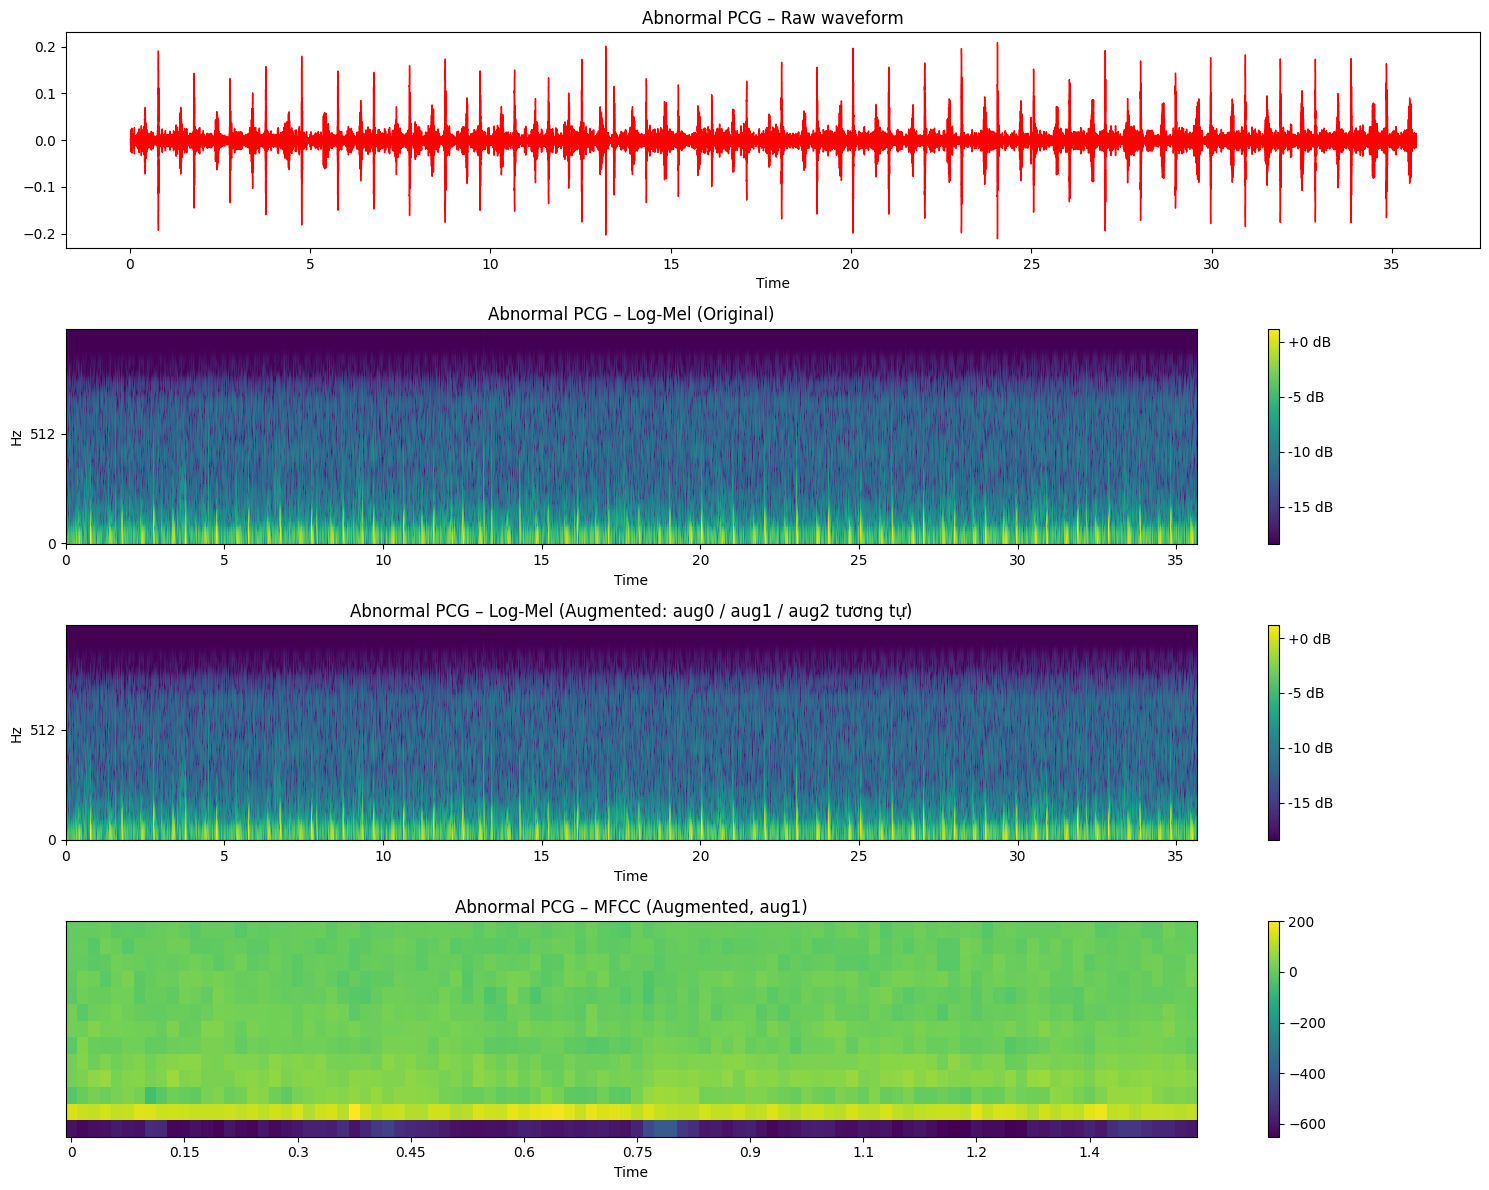

In [30]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path

# ========================
# ABNORMAL SAMPLE (RAW + AUGMENTED)
# ========================

abnormal_file = Path(abnormal_file)          # ví dụ: a0077.wav hoặc a0001.wav
abnormal_basename = abnormal_file.stem        # a0077
folder_letter = abnormal_basename[0]

wav_path = original_audio_root / f"training-{folder_letter}" / abnormal_file.name
print(f"[ABNORMAL] Audio path: {wav_path}")

# 1. Load raw abnormal audio
audio_abn, sr = librosa.load(wav_path, sr=None)
print(f"[ABNORMAL] Length: {len(audio_abn)} | Duration: {len(audio_abn)/sr:.2f}s | SR: {sr}")

# 2. Load original features
logmel_abn = np.load(logmel_folder / f"{abnormal_basename}.npy")
mfcc_abn   = np.load(mfcc_folder / f"{abnormal_basename}.npy")

print(f"[ABNORMAL] LogMel original shape: {logmel_abn.shape}")
print(f"[ABNORMAL] MFCC original shape : {mfcc_abn.shape}")

# 3. Load augmented features (aug0, aug1, aug2)
aug_logmels = []
aug_mfccs   = []

for i in range(3):
    aug_name = f"{abnormal_basename}_aug{i}.npy"

    logmel_aug = np.load(logmel_folder / aug_name)
    mfcc_aug   = np.load(mfcc_folder / aug_name)

    aug_logmels.append(logmel_aug)
    aug_mfccs.append(mfcc_aug)

    print(f"[ABNORMAL] Loaded {aug_name} | LogMel shape: {logmel_aug.shape}")

# ========================
# Visualization
# ========================

plt.figure(figsize=(15, 12))

# (1) Waveform (raw)
plt.subplot(4, 1, 1)
librosa.display.waveshow(audio_abn, sr=sr, color="red")
plt.title("Abnormal PCG – Raw waveform")

# (2) Log-Mel original
plt.subplot(4, 1, 2)
librosa.display.specshow(
    logmel_abn,
    sr=sr,
    hop_length=int(sr * 15 / 1000),
    x_axis="time",
    y_axis="mel",
    cmap="viridis"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Abnormal PCG – Log-Mel (Original)")

# (3) Log-Mel augmented (3 mẫu)
plt.subplot(4, 1, 3)
librosa.display.specshow(
    aug_logmels[0],
    sr=sr,
    hop_length=int(sr * 15 / 1000),
    x_axis="time",
    y_axis="mel",
    cmap="viridis"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Abnormal PCG – Log-Mel (Augmented: aug0 / aug1 / aug2 tương tự)")

# (4) MFCC augmented (ví dụ aug1)
plt.subplot(4, 1, 4)
librosa.display.specshow(
    aug_mfccs[1],
    sr=sr,
    hop_length=int(sr * 15 / 1000),
    x_axis="time",
    cmap="viridis"
)
plt.colorbar()
plt.title("Abnormal PCG – MFCC (Augmented, aug1)")

plt.tight_layout()
plt.show()

## Create .h5py for logmel_features

In [31]:
# Cell: Chuyển tất cả file .npy sang một file .h5 lớn (CHỈ CHẠY 1 LẦN)
import numpy as np
import h5py
from pathlib import Path
from tqdm.notebook import tqdm  # Để có progress bar đẹp

FEATURES_DIR = PROJECT_PATH /"logmel_features"  # Thư mục chứa các .npy
OUTPUT_H5 = PROJECT_PATH /"data"/"logmel_features.h5"   # File output

if OUTPUT_H5.exists():
    print(f"File {OUTPUT_H5} ĐÃ TỒN TẠI – bỏ qua việc tạo lại.")
    print("Nếu muốn tạo lại, xóa file này trước: !rm '{OUTPUT_H5}'")
else:
    print("Đang chuyển đổi tất cả .npy sang .h5 ... (có thể mất vài phút tùy số lượng file)")
    npy_files = list(FEATURES_DIR.glob("*.npy"))
    print(f"Tìm thấy {len(npy_files)} file .npy")

    with h5py.File(OUTPUT_H5, 'w') as f_out:
      for npy_file in tqdm(npy_files):
          key = npy_file.stem
          data = np.load(npy_file)

          # Chỉ chấp nhận (M, T)
          assert data.ndim == 2, f"{key} has invalid shape {data.shape}"

          f_out.create_dataset(
              key,
              data=data.astype(np.float32),
              compression="gzip"
          )

    print(f"HOÀN THÀNH! File đã tạo: {OUTPUT_H5}")

Đang chuyển đổi tất cả .npy sang .h5 ... (có thể mất vài phút tùy số lượng file)
Tìm thấy 5235 file .npy


  0%|          | 0/5235 [00:00<?, ?it/s]

HOÀN THÀNH! File đã tạo: /content/drive/MyDrive/AutomaticHeartSoundClassification-main/data/logmel_features.h5


In [32]:
import h5py

OUTPUT_H5 = PROJECT_PATH /"data"/"logmel_features.h5"
h5_path = str(OUTPUT_H5)

with h5py.File(h5_path, "r") as f:
    for key in f.keys():
        obj = f[key]
        if isinstance(obj, h5py.Group):
            print(f"[GROUP]   {key}")
            for subkey in obj.keys():
                subobj = obj[subkey]
                if isinstance(subobj, h5py.Dataset):
                    print(f"    └── [DATASET] {subkey}, shape={subobj.shape}")
        else:
            print(f"[DATASET] {key}, shape={obj.shape}")


Streaming output truncated to the last 5000 lines.
[DATASET] a0075_aug1, shape=(128, 2383)
[DATASET] a0075_aug2, shape=(128, 2383)
[DATASET] a0076, shape=(128, 2378)
[DATASET] a0076_aug0, shape=(128, 2378)
[DATASET] a0076_aug1, shape=(128, 2378)
[DATASET] a0076_aug2, shape=(128, 2378)
[DATASET] a0077, shape=(128, 2383)
[DATASET] a0077_aug0, shape=(128, 2383)
[DATASET] a0077_aug1, shape=(128, 2383)
[DATASET] a0077_aug2, shape=(128, 2383)
[DATASET] a0078, shape=(128, 2383)
[DATASET] a0078_aug0, shape=(128, 2383)
[DATASET] a0078_aug1, shape=(128, 2383)
[DATASET] a0078_aug2, shape=(128, 2383)
[DATASET] a0079, shape=(128, 2044)
[DATASET] a0079_aug0, shape=(128, 2044)
[DATASET] a0079_aug1, shape=(128, 2044)
[DATASET] a0079_aug2, shape=(128, 2044)
[DATASET] a0080, shape=(128, 2067)
[DATASET] a0081, shape=(128, 2378)
[DATASET] a0082, shape=(128, 2044)
[DATASET] a0082_aug0, shape=(128, 2044)
[DATASET] a0082_aug1, shape=(128, 2044)
[DATASET] a0082_aug2, shape=(128, 2044)
[DATASET] a0083, shape=(

## Create .h5py for MFCC

In [33]:
# ==============================
# MERGE MFCC .npy → HDF5
# ==============================
import numpy as np
import h5py
from pathlib import Path
from tqdm.notebook import tqdm

MFCC_DIR = PROJECT_PATH / "mfcc_features"          # Thư mục chứa MFCC .npy
OUTPUT_H5 = PROJECT_PATH / "data" / "mfcc_features.h5"

if OUTPUT_H5.exists():
    print(f"File {OUTPUT_H5} đã tồn tại – bỏ qua.")
else:
    npy_files = sorted(MFCC_DIR.glob("*.npy"))
    print(f"🔎 Found {len(npy_files)} MFCC files")

    with h5py.File(OUTPUT_H5, "w") as f_out:
        for npy_file in tqdm(npy_files, desc="Converting MFCC"):
            key = npy_file.stem
            data = np.load(npy_file)

            # MFCC chuẩn: (n_mfcc, time)
            assert data.ndim == 2, f"{key} invalid shape {data.shape}"

            f_out.create_dataset(
                key,
                data=data.astype(np.float32),
                compression="gzip"
            )

    print(f"✅ MFCC HDF5 created: {OUTPUT_H5}")

🔎 Found 5235 MFCC files


Converting MFCC:   0%|          | 0/5235 [00:00<?, ?it/s]

✅ MFCC HDF5 created: /content/drive/MyDrive/AutomaticHeartSoundClassification-main/data/mfcc_features.h5


In [34]:
# ==============================
# INSPECT MFCC HDF5
# ==============================
import h5py

h5_path = str(PROJECT_PATH / "data" / "mfcc_features.h5")

with h5py.File(h5_path, "r") as f:
    print(f"Total samples: {len(f.keys())}\n")
    for i, key in enumerate(f.keys()):
        print(f"[DATASET] {key}, shape={f[key].shape}")

Streaming output truncated to the last 5000 lines.
[DATASET] a0075_aug1, shape=(13, 100)
[DATASET] a0075_aug2, shape=(13, 100)
[DATASET] a0076, shape=(13, 100)
[DATASET] a0076_aug0, shape=(13, 100)
[DATASET] a0076_aug1, shape=(13, 100)
[DATASET] a0076_aug2, shape=(13, 100)
[DATASET] a0077, shape=(13, 100)
[DATASET] a0077_aug0, shape=(13, 100)
[DATASET] a0077_aug1, shape=(13, 100)
[DATASET] a0077_aug2, shape=(13, 100)
[DATASET] a0078, shape=(13, 100)
[DATASET] a0078_aug0, shape=(13, 100)
[DATASET] a0078_aug1, shape=(13, 100)
[DATASET] a0078_aug2, shape=(13, 100)
[DATASET] a0079, shape=(13, 100)
[DATASET] a0079_aug0, shape=(13, 100)
[DATASET] a0079_aug1, shape=(13, 100)
[DATASET] a0079_aug2, shape=(13, 100)
[DATASET] a0080, shape=(13, 100)
[DATASET] a0081, shape=(13, 100)
[DATASET] a0082, shape=(13, 100)
[DATASET] a0082_aug0, shape=(13, 100)
[DATASET] a0082_aug1, shape=(13, 100)
[DATASET] a0082_aug2, shape=(13, 100)
[DATASET] a0083, shape=(13, 100)
[DATASET] a0083_aug0, shape=(13, 100)
[

In [35]:
import pandas as pd
from pathlib import Path

# Load label gốc (FULL)
df_base = pd.read_csv(PROJECT_PATH / "data" / "label.csv")

# Chuẩn hoá ID gốc
df_base["id"] = df_base["filename"].apply(lambda x: Path(x).stem)

label_map = dict(zip(df_base["id"], df_base["label"]))

rows = []

with h5py.File(h5_path, "r") as f:
    for key in f.keys():
        base = key.split("_aug")[0]
        if base in label_map:
            rows.append({
                "filename": key,
                "label": label_map[base]
            })
        else:
            print("⚠️ Missing base label:", key)

df_full = pd.DataFrame(rows)
df_full.to_csv(PROJECT_PATH / "data" / "label_balanced.csv", index=False)

print("✅ label_balanced.csv created")
print(df_full["label"].value_counts())


✅ label_balanced.csv created
label
1    2660
0    2575
Name: count, dtype: int64


In [36]:
# =========================
# Load label CSV
# =========================
label_csv = PROJECT_PATH / "data" / "label_balanced.csv"
df = pd.read_csv(label_csv)

# Map: base_id -> label
label_map = {
    row["filename"]: row["label"]
    for _, row in df.iterrows()
}

def base_id(sample_id: str) -> str:
    """Chuẩn hoá ID: bỏ _augX nếu có"""
    return sample_id.split("_aug")[0]

# =========================
# Count labels in HDF5
# =========================
label_counter = Counter()
unknown = []

with h5py.File(h5_path, "r") as f:
    for name in f.keys():
        bid = base_id(name)
        if bid in label_map:
            if label_map[bid] == 1:
                label_counter["Abnormal"] += 1
            else:
                label_counter["Normal"] += 1
        else:
            label_counter["Unknown"] += 1
            unknown.append(name)

# =========================
# Print statistics
# =========================
total = sum(label_counter.values())

print("\n=== CLASS DISTRIBUTION (CSV-BASED) ===")
print(f"Tổng số mẫu: {total}")

for cls, cnt in label_counter.items():
    print(f"{cls}: {cnt} ({cnt/total*100:.2f}%)")

if unknown:
    print(f"\n⚠️ Unknown samples: {len(unknown)}")
    print("Ví dụ:", unknown[:10])


=== CLASS DISTRIBUTION (CSV-BASED) ===
Tổng số mẫu: 5235
Abnormal: 2660 (50.81%)
Normal: 2575 (49.19%)


In [37]:
import h5py
import pandas as pd
from collections import Counter
from pathlib import Path

def print_class_distribution(h5_path, label_csv_path, title=None):
    """
    In ra tỷ lệ Normal / Abnormal trong file .h5
    """
    # Load label.csv
    df = pd.read_csv(label_csv_path)
    df["basename"] = df["filename"].apply(lambda x: Path(x).stem)

    label_dict = dict(zip(df["basename"], df["label"]))

    counter = Counter()

    with h5py.File(h5_path, "r") as f:
        for key in f.keys():
            if key not in label_dict:
                counter["Unknown"] += 1
                continue

            if label_dict[key] == 1:
                counter["Abnormal"] += 1
            else:
                counter["Normal"] += 1

    total = counter["Normal"] + counter["Abnormal"]

    if title:
        print(f"\n=== {title} ===")

    print(f"Tổng số mẫu: {total}")
    print(f"Normal  : {counter['Normal']} ({counter['Normal']/total*100:.2f}%)")
    print(f"Abnormal: {counter['Abnormal']} ({counter['Abnormal']/total*100:.2f}%)")

    if counter["Unknown"] > 0:
        print(f"⚠️ Unknown (không có nhãn): {counter['Unknown']}")

# Test

In [ ]:
DATASET_PATH = Path('/content/drive/MyDrive/physionet2016')
PROJECT_PATH = Path('/content/drive/MyDrive/AutomaticHeartSoundClassification-main')

VALIDATION_FOLDER = DATASET_PATH / 'validation'

In [ ]:
LOGMEL_FOLDER_VAL = PROJECT_PATH / 'logmel_features_validation'
LOGMEL_FOLDER_VAL.mkdir(parents=True, exist_ok=True)

MFCC_FOLDER_VAL = PROJECT_PATH / 'mfcc_features_validation'
MFCC_FOLDER_VAL.mkdir(parents=True, exist_ok=True)

In [ ]:
OUTPUT_H5_VAL = PROJECT_PATH / 'data' / 'logmel_features_validation.h5'
OUTPUT_H5_VAL.parent.mkdir(parents=True, exist_ok=True)

In [ ]:
ref_path = VALIDATION_FOLDER / 'REFERENCE.csv'
if not ref_path.exists():
    raise FileNotFoundError(f"Không tìm thấy REFERENCE.csv tại {ref_path}")

df_val = pd.read_csv(ref_path, header=None, names=['basename', 'label'])
df_val['filename'] = [str(VALIDATION_FOLDER / (base + '.wav')) for base in df_val['basename']]
df_val['label'] = (df_val['label'] + 1) // 2  # -1 -> 0, 1 -> 1 (giống training)

# Lưu label.csv cho validation (tùy chọn, để sau này dễ load)
val_label_path = PROJECT_PATH / 'data' / 'label_validation.csv'
df_val[['filename', 'label']].to_csv(val_label_path, index=False)
print(f"Đã tạo label_validation.csv với {len(df_val)} mẫu.")

In [ ]:
# -------------------------- Tham số trích xuất --------------------------
mel_bins = 128
hoplen = 15    # ms
winlen = 25    # ms
EPS = 1e-8

## Convert to LogMel and MFCC

In [ ]:
import os
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter
from pathlib import Path

# =========================
# read_audio()
# augment_audio()
# PROJECT_PATH
# MfccExtractor()
# LogMelExtractor()
# =========================

if __name__ == "__main__":

    df = pd.read_csv(PROJECT_PATH / "data" / "label_validation.csv")

    logmel_folder = PROJECT_PATH / 'logmel_features_validation'
    mfcc_folder   = PROJECT_PATH / 'mfcc_features_validation'

    os.makedirs(logmel_folder, exist_ok=True)
    os.makedirs(mfcc_folder, exist_ok=True)

    # ===== Class balancing =====
    label_counts = Counter(df["label"])
    n_normal   = label_counts[0]
    n_abnormal = label_counts[1]

    target_abnormal = n_normal
    augment_per_abnormal = int(
        np.ceil((target_abnormal - n_abnormal) / n_abnormal)
    )

    print("=== ORIGINAL DISTRIBUTION ===")
    print(f"Normal  : {n_normal}")
    print(f"Abnormal: {n_abnormal}")
    print(f"Augment per abnormal sample: {augment_per_abnormal}")

    # ===== Feature parameters =====
    mel_bins = 128
    n_mfcc   = 13
    hoplen   = 15   # ms
    winlen   = 25   # ms
    T_fixed  = 100
    # =========================
    # Feature extraction
    # =========================
    for _, row in tqdm(df.iterrows(), total=len(df)):

        filename = row["filename"]
        label    = row["label"]

        audio, fs = read_audio(filename, filter=True)
        basename = Path(filename).stem

        # ===== ORIGINAL SAMPLE =====
        logmel = LogMelExtractor(
            audio, fs,
            mel_bins=mel_bins,
            hoplen=hoplen,
            winlen=winlen
        )

        mfcc = MfccExtractor(
            audio, fs,
            n_mfcc=n_mfcc,
            hoplen=hoplen,
            winlen=winlen,
            T_fixed=T_fixed
        )

        np.save(logmel_folder / f"{basename}.npy", logmel)
        np.save(mfcc_folder   / f"{basename}.npy", mfcc)

    print("\n✅ Feature extraction + augmentation completed.")


## LogMel to .h5

In [ ]:
# Cell: Chuyển tất cả file .npy sang một file .h5 lớn (CHỈ CHẠY 1 LẦN)
import numpy as np
import h5py
from pathlib import Path
from tqdm.notebook import tqdm  # Để có progress bar đẹp

FEATURES_DIR = PROJECT_PATH /"logmel_features_validation"  # Thư mục chứa các .npy
OUTPUT_H5 = PROJECT_PATH /"data"/"logmel_features_validation.h5"   # File output

if OUTPUT_H5.exists():
    print(f"File {OUTPUT_H5} ĐÃ TỒN TẠI – bỏ qua việc tạo lại.")
    print("Nếu muốn tạo lại, xóa file này trước: !rm '{OUTPUT_H5}'")
else:
    print("Đang chuyển đổi tất cả .npy sang .h5 ... (có thể mất vài phút tùy số lượng file)")
    npy_files = list(FEATURES_DIR.glob("*.npy"))
    print(f"Tìm thấy {len(npy_files)} file .npy")

    with h5py.File(OUTPUT_H5, 'w') as f_out:
      for npy_file in tqdm(npy_files):
          key = npy_file.stem
          data = np.load(npy_file)

          # Chỉ chấp nhận (M, T)
          assert data.ndim == 2, f"{key} has invalid shape {data.shape}"

          f_out.create_dataset(
              key,
              data=data.astype(np.float32),
              compression="gzip"
          )

    print(f"HOÀN THÀNH! File đã tạo: {OUTPUT_H5}")

In [ ]:
# =========================
# Load label CSV
# =========================
label_csv = PROJECT_PATH / "data" / "label_validation.csv"
df = pd.read_csv(label_csv)
h5_path = str(OUTPUT_H5)
# Map: base_id -> label
label_map = {
    Path(row["filename"]).stem: row["label"]
    for _, row in df.iterrows()
}

def base_id(sample_id: str) -> str:
    """Chuẩn hoá ID: bỏ _augX nếu có"""
    return sample_id.split("_aug")[0]

# =========================
# Count labels in HDF5
# =========================
label_counter = Counter()
unknown = []

with h5py.File(h5_path, "r") as f:
    for name in f.keys():
        bid = base_id(name)
        if bid in label_map:
            if label_map[bid] == 1:
                label_counter["Abnormal"] += 1
            else:
                label_counter["Normal"] += 1
        else:
            label_counter["Unknown"] += 1
            unknown.append(name)

# =========================
# Print statistics
# =========================
total = sum(label_counter.values())

print("\n=== CLASS DISTRIBUTION (CSV-BASED) ===")
print(f"Tổng số mẫu: {total}")

for cls, cnt in label_counter.items():
    print(f"{cls}: {cnt} ({cnt/total*100:.2f}%)")

if unknown:
    print(f"\n⚠️ Unknown samples: {len(unknown)}")
    print("Ví dụ:", unknown[:10])

## MFCC to .h5

In [ ]:
# ==============================
# MERGE MFCC .npy → HDF5
# ==============================
import numpy as np
import h5py
from pathlib import Path
from tqdm.notebook import tqdm

MFCC_DIR = PROJECT_PATH / "mfcc_features_validation"          # Thư mục chứa MFCC .npy
OUTPUT_H5 = PROJECT_PATH / "data" / "mfcc_features_validation.h5"

if OUTPUT_H5.exists():
    print(f"File {OUTPUT_H5} đã tồn tại – bỏ qua.")
else:
    npy_files = sorted(MFCC_DIR.glob("*.npy"))
    print(f"🔎 Found {len(npy_files)} MFCC files")

    with h5py.File(OUTPUT_H5, "w") as f_out:
        for npy_file in tqdm(npy_files, desc="Converting MFCC"):
            key = npy_file.stem
            data = np.load(npy_file)

            # MFCC chuẩn: (n_mfcc, time)
            assert data.ndim == 2, f"{key} invalid shape {data.shape}"

            f_out.create_dataset(
                key,
                data=data.astype(np.float32),
                compression="gzip"
            )

    print(f"✅ MFCC HDF5 created: {OUTPUT_H5}")

In [ ]:
# =========================
# Load label CSV
# =========================
label_csv = PROJECT_PATH / "data" / "label_validation.csv"
df = pd.read_csv(label_csv)
h5_path = str(OUTPUT_H5)
# Map: base_id -> label
label_map = {
    Path(row["filename"]).stem: row["label"]
    for _, row in df.iterrows()
}

def base_id(sample_id: str) -> str:
    """Chuẩn hoá ID: bỏ _augX nếu có"""
    return sample_id.split("_aug")[0]

# =========================
# Count labels in HDF5
# =========================
label_counter = Counter()
unknown = []

with h5py.File(h5_path, "r") as f:
    for name in f.keys():
        bid = base_id(name)
        if bid in label_map:
            if label_map[bid] == 1:
                label_counter["Abnormal"] += 1
            else:
                label_counter["Normal"] += 1
        else:
            label_counter["Unknown"] += 1
            unknown.append(name)

# =========================
# Print statistics
# =========================
total = sum(label_counter.values())

print("\n=== CLASS DISTRIBUTION (CSV-BASED) ===")
print(f"Tổng số mẫu: {total}")

for cls, cnt in label_counter.items():
    print(f"{cls}: {cnt} ({cnt/total*100:.2f}%)")

if unknown:
    print(f"\n⚠️ Unknown samples: {len(unknown)}")
    print("Ví dụ:", unknown[:10])